# Choice of the learner

This notebooks contains some practical recommendations to choose the right learner and evaluate different learners for the corresponding nuisance components.

For the example, we will work with a IRM, but all of the important components are directly usable for all other models too.

To be able to compare the properties of different learners, we will start by setting the true treatment parameter to zero, fix some other parameters of the data generating process and generate several datasets.

In [91]:
import numpy as np
import doubleml as dml

from doubleml.datasets import make_irm_data

theta = 0
n_obs = 500
dim_x = 5
n_rep = 100

np.random.seed(42)
datasets = []
for i in range(n_rep):
    data = make_irm_data(theta=theta, n_obs=n_obs, dim_x=dim_x, return_type='DataFrame')
    datasets.append(dml.DoubleMLData(data, 'y', 'd'))

## Comparing different learners
For simplicity, we will restrict ourselves to the comparison of two different types and evaluate a learner of linear type and random forest type for each nuisance component (with default parameters).

In [92]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegressionCV

from sklearn.base import clone

learner_list = [{'ml_g': LinearRegression(), 'ml_m': LogisticRegressionCV()},
                {'ml_g': RandomForestRegressor(), 'ml_m': LogisticRegressionCV()},
                {'ml_g': LinearRegression(), 'ml_m': RandomForestClassifier()},
                {'ml_g': RandomForestRegressor(), 'ml_m': RandomForestClassifier()}]

In all combinations, we now can try to evaluate four different IRM models. To make the comparison fair, we will apply all different models to the same cross-fitting samples.

### Simple Approach

At first, we will look at the most straightforward approach using the inbuild RMSE. The `rmses` attribute contains the out-of-sample RMSE for the nuisance functions. We will save all RMSEs and the corresponding treatment estimates for all combinations of learners over all repetitions.

In [93]:
from doubleml._utils_resampling import DoubleMLResampling

coefs = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
rmses_ml_m = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
rmses_ml_g0 = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)
rmses_ml_g1 = np.full(shape=(n_rep, len(learner_list)), fill_value=np.nan)

for i_rep in range(n_rep):
    print(i_rep)
    dml_data = datasets[i_rep]
    # define the sample splitting
    smpls = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n_obs, apply_cross_fitting=True, stratify=dml_data.d).split_samples()
    
    for i_learners, learners in enumerate(learner_list):
        np.random.seed(42)
        dml_irm = dml.DoubleMLIRM(dml_data,
                                  ml_g=clone(learners['ml_g']),
                                  ml_m=clone(learners['ml_m']),
                                  draw_sample_splitting=False)
        dml_irm.set_sample_splitting(smpls)
        dml_irm.fit(n_jobs_cv=5)

        coefs[i_rep, i_learners] = dml_irm.coef[0]
        rmses_ml_m[i_rep, i_learners] = dml_irm.rmses['ml_m']
        rmses_ml_g0[i_rep, i_learners] = dml_irm.rmses['ml_g0']
        rmses_ml_g1[i_rep, i_learners] = dml_irm.rmses['ml_g1']

c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictio

Next, let us take a look at the corresponding results

In [94]:
import pandas as pd

colnames = ['Linear + Logit','RF + Logit', 'Linear + RF', 'RF + RF']

df_coefs = pd.DataFrame(coefs, columns=colnames)
df_ml_m = pd.DataFrame(rmses_ml_m, columns=colnames)
df_ml_g0 = pd.DataFrame(rmses_ml_g0, columns=colnames)
df_ml_g1 = pd.DataFrame(rmses_ml_g1, columns=colnames)

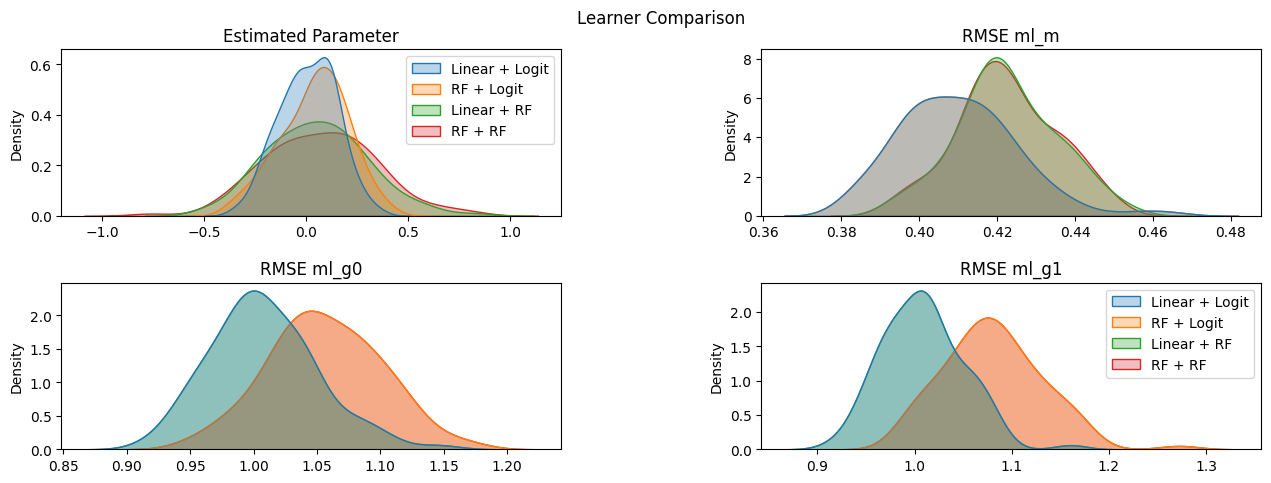

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 5))
fig.suptitle('Learner Comparison')


sns.kdeplot(data=df_coefs,ax=axes[0][0], fill=True, alpha=0.3)
sns.kdeplot(data=df_ml_m, ax=axes[0][1], fill=True, alpha=0.3, legend=False)
sns.kdeplot(data=df_ml_g0, ax=axes[1][0], fill=True, alpha=0.3, legend=False)
sns.kdeplot(data=df_ml_g1, ax=axes[1][1], fill=True, alpha=0.3)

axes[0][0].title.set_text('Estimated Parameter')
axes[0][1].title.set_text('RMSE ml_m')
axes[1][0].title.set_text('RMSE ml_g0')
axes[1][1].title.set_text('RMSE ml_g1')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

We can now easily observe that in this setting, the linear learners are able to approximate the corresponding nuisance functions better than the random forest (as should be expected since the data is generated accordingly).

Let us take a look at what would have happend if a each repetition for each nuisance element, we would have selected the learner with smallest out-of-sample rmse. Remark that we cannot select different learners for `ml_g0` and `ml_g1`.

In [129]:
selected_learners = (rmses_ml_m * (rmses_ml_g0 + rmses_ml_g1)).argmin(axis=1)
selected_learners

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int64)

In [133]:
selected_coefs = np.array([coefs[i_rep, selected_learners[i_rep]] for i_rep in range(n_rep)])

In [135]:
avg_abs_bias = np.median(abs(np.column_stack((selected_coefs,coefs))), axis=0)

avg_abs_bias

array([0.10900322, 0.10900322, 0.13407646, 0.17739239, 0.18899048])

## Different evaluation metrics

If one wants to evaluate a learner based on some other metric/loss it is possible to use the inbuilt `evaluate_learners` method (LINK TO DOCUMENTATION).
Without further arguments this will default to the RMSE for all nuisance components and result in the same output as the `rmses` attribute.

In [141]:
print(dml_irm.evaluate_learners())
print(dml_irm.rmses)

{'ml_g0': array([[1.04026602]]), 'ml_g1': array([[1.1640504]]), 'ml_m': array([[0.42331596]])}
{'ml_g0': array([[1.04026602]]), 'ml_g1': array([[1.1640504]]), 'ml_m': array([[0.42331596]])}


To evaluate a self-defined metric, the user has to hand over a callable. In this example, we define the mean absolute deviation as an error metric.

Remark that the metric should be able to handle `nan` values, since e.g. in the IRM model the learner `ml_g` is used to onto two different subsamples. As a result, we have two different nuisance components for

\begin{align*}
g_0(x) &= \mathbb{E}[Y|X=x, D=0] \\
g_1(x) &= \mathbb{E}[Y|X=x, D=1]
\end{align*}

which are both fitted with the learner `ml_g`. Of course, we can only observe the target value for $g_0(x)$ if $D=0$ and vice versa, resulting in `nan` values for all other observations.

In [143]:
from sklearn.metrics import mean_absolute_error

def mae(y_true, y_pred):
    subset = np.logical_not(np.isnan(y_true))
    return mean_absolute_error(y_true[subset], y_pred[subset])

dml_irm.evaluate_learners(metric=mae)

{'ml_g0': array([[0.84112612]]),
 'ml_g1': array([[0.93721]]),
 'ml_m': array([[0.3396]])}

Another option is to access the out-of-sample predictions and target values for the nuisance elements via the `nuisance_targets` and `predictions` attributes.

In [139]:
dml_irm.nuisance_targets['ml_g1']
dml_irm.predictions['ml_g1']

array([[[-1.31415797e+00]],

       [[ 1.89574046e+00]],

       [[-8.11951198e-01]],

       [[ 4.69146466e-01]],

       [[ 3.88580491e-01]],

       [[ 1.21982509e+00]],

       [[ 4.11864512e-01]],

       [[ 7.84690593e-01]],

       [[-8.51590540e-01]],

       [[-1.91949694e-01]],

       [[ 8.96768423e-01]],

       [[ 1.82616373e+00]],

       [[-1.34311177e+00]],

       [[-4.35436834e-01]],

       [[-2.11423306e-01]],

       [[-5.13396854e-02]],

       [[-4.80604427e-01]],

       [[ 1.31289044e+00]],

       [[-6.32344159e-02]],

       [[-9.03998139e-01]],

       [[ 6.68586276e-01]],

       [[ 7.67106154e-01]],

       [[ 6.89282584e-01]],

       [[ 1.12343621e+00]],

       [[-7.96762899e-01]],

       [[ 1.36233930e+00]],

       [[ 6.84653337e-01]],

       [[-4.66847490e-01]],

       [[-8.94678941e-01]],

       [[ 1.57397627e+00]],

       [[-9.29200890e-01]],

       [[-8.18330004e-01]],

       [[-1.29635386e-01]],

       [[ 1.70003449e+00]],

       [[-5.27

For most models minimizing the RMSE for each learner should result in improved performance as the theoretical backbone of the DML Framework is build on $\ell_2$-convergence rates for the nuisance estimates (ADD CITATION). But for some models (e.g. classification learners) it might be helpful to further check other error metrics (as ADD EXAMPLES) to gain a overview whether the nuisance function can be approximated sufficiently well. 

Of course, if one has some prior knowledge on functional form assumptions (e.g. linearity as in the IRM example above) using these learners will usually improve the performance of the estimator and might speed up computation time.

# Minimize Computation Time

The choice of the learner has a huge impact on the computation time of the DoubleML models. As the largest part of the computation time is usually used to train the learners for the nuisance components, some clever choices of learners and hyperparameters can speed up the computation time. 

Resourcewise, most implementations support the `n_jobs_cv` argument, which can parallelize the k-fold estimation and might speed up the calculation nearly up to $k$-times if the resources are available.

In [151]:
from time import perf_counter

np.random.seed(42)
dml_data = dml.DoubleMLData(make_irm_data(theta=0, n_obs=500, dim_x=20, return_type='DataFrame'), 'y', 'd')

# define the sample splitting
smpls = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n_obs, apply_cross_fitting=True, stratify=dml_data.d).split_samples()

dml_irm = dml.DoubleMLIRM(dml_data,
                          ml_g=RandomForestRegressor(),
                          ml_m=RandomForestClassifier(),
                          draw_sample_splitting=False)
dml_irm.set_sample_splitting(smpls)

np.random.seed(42)
t_1_start = perf_counter()
dml_irm.fit()
t_1_stop = perf_counter()
print(f'Time without parallelization of crossfitting: {t_1_stop - t_1_start} seconds')

np.random.seed(42)
t_2_start = perf_counter()
dml_irm.fit(n_jobs_cv=5)
t_2_stop = perf_counter()
print(f'Time with parallelization of crossfitting: {t_2_stop - t_2_start} seconds')
print(f'Speed of factor {(t_1_stop - t_1_start) / (t_2_stop - t_2_start)}')

Time without parallelization of crossfitting: 14.104337099997792 seconds
Time with parallelization of crossfitting: 3.778224500012584 seconds
Speed of factor 3.7330595627525085


Other more helpful ways to improve computation time will largly depend on the implemented learner. Of course linear learners are quite fast 

13.40625